In [2]:
from matplotlib import pyplot as plt
import numpy as np
import xraydb

# Read the MCA output file
def read_file(filepath: str):
    with open(filepath, "r") as f:
        lines = f.readlines()
    lines = list(map(lambda x: x.strip(), lines))

    bin_width = None
    in_data_block = False
    num_bins = None
    data = []
    for i in range(len(lines)):
        if lines[i - 1] == "$DATA:":
            in_data_block = True
            num_bins = int(lines[i].split()[1]) + 1
        elif in_data_block and len(data) < num_bins:
            data.append(int(lines[i]))
            if len(data) == num_bins:
                in_data_block = False
        elif lines[i] == "$ENER_FIT:":
            bin_width = float(lines[i+1].split()[1])
            break
    
    return data, bin_width

data, bin_width = read_file("data/ta.Spe")

In [3]:
def find_peaks(data, n=10):
    peaks = []
    for i in range(n, len(data) - n):
        prev_avg = sum(data[i - n:i]) / float(n)
        post_avg = sum(data[i+1:i+n+1]) / float(n)
        if data[i] > prev_avg and data[i] > post_avg:
            peaks.append(i)
    return peaks
            
# find_peaks(data, 1)

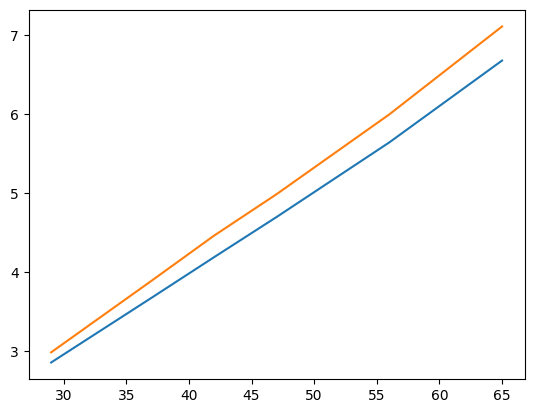

In [4]:
Z = np.array([29, 37, 42, 47, 56, 65])
E_ka = np.array([8.17, 13.51, 17.56, 22.09, 31.86, 44.63])
E_kb = np.array([8.92, 15.14, 19.92, 24.89, 35.99, 50.58])
lhm_ka = np.array([7.71, 13.14, 17.23, 21.60, 31.35, 43.79])
rhm_ka = np.array([8.73, 13.93, 18.02, 22.50, 32.28, 45.23])
lhm_kb = np.array([8.42, 14.68, 19.41, 24.44, 35.62, 50.06])
rhm_kb = np.array([9.43, 15.60, 20.30, 25.39, 36.60, 51.27])
fwhm_ka = rhm_ka - lhm_ka
fwhm_kb = rhm_kb - lhm_kb

plt.plot(Z, np.sqrt(E_ka))
plt.plot(Z, np.sqrt(E_kb))
plt.show()

In [5]:
from scipy import stats
from scipy.optimize import curve_fit

def line(x, m, b):
    return m*x + b

popt_ka, pcov_ka = curve_fit(f=line, xdata=Z, ydata=np.sqrt(E_ka), sigma=fwhm_ka, p0=[1,0.3], absolute_sigma=True)
popt_kb, pcov_kb = curve_fit(f=line, xdata=Z, ydata=np.sqrt(E_kb), sigma=fwhm_kb, p0=[1,0.3], absolute_sigma=True)
uncert = np.sqrt(np.diag(pcov_ka))
print(popt_ka, pcov_ka)

[ 0.10485751 -0.20669026] [[ 1.44658997e-03 -6.34171403e-02]
 [-6.34171403e-02  2.92221715e+00]]


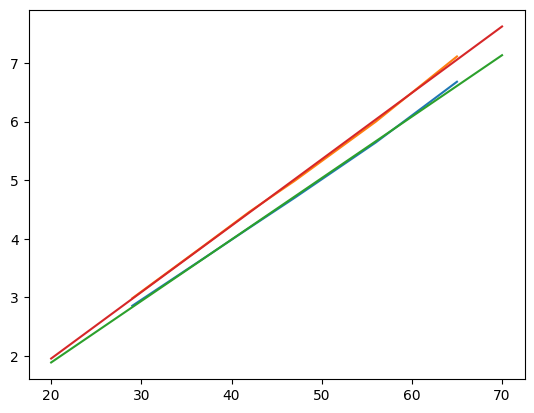

In [6]:
x = np.linspace(20, 70, 500)
plt.plot(Z, np.sqrt(E_ka))
plt.plot(Z, np.sqrt(E_kb))
plt.plot(x, line(x, *popt_ka))
plt.plot(x, line(x, *popt_kb))
plt.show()

In [7]:
print("C_ka = ", popt_ka[0])
print("C_kb = ", popt_kb[0])

print("Sigma_ka = ", popt_ka[1] / -popt_ka[0])
print("Sigma_kb = ", popt_kb[1] / -popt_kb[0])

C_ka =  0.1048575052273781
C_kb =  0.1133150975778887
Sigma_ka =  1.9711537411059037
Sigma_kb =  2.7235338206927695


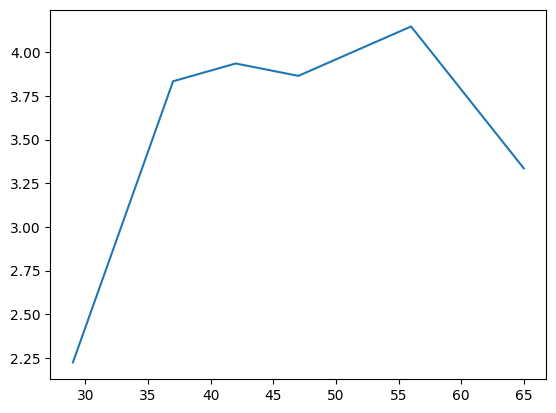

In [8]:
# Deterine ratios of counts of K_alpha1 and K_alpha2 lines
# Can't see these, but could compare with beta
ab_counts_ratio = [2759/1241, 10004/2609, 10006/2542, 10023/2593, 10010/2413,10420/3124]
plt.plot(Z, ab_counts_ratio)

In [9]:
# Doublet separation in energy vary with Z as (Z - sigma)^4


In [10]:
# Below analyzing the ratios of Escape Peak counts to normal peak

In [11]:
counts = {
    "alpha_escape": np.array([-1, 598, 1026, 662, 298, 179]),
    "beta_escape" : np.array([-1, 411, 264, 170, 80, -1]),
    "alpha"       : np.array([2759, 10004, 10006, 10023, 10010, 10420]),
    "beta"        : np.array([1241, 2609, 2542, 2593, 2413, 3124])
}

In [12]:
ratio_alpha = counts["alpha_escape"] / counts["alpha"]
ratio_beta = counts["beta_escape"] / counts["beta"]
ratio_alpha = ratio_alpha[1:]
ratio_beta = ratio_beta[1:-1]
print(ratio_alpha)
print(ratio_beta)

[0.05977609 0.10253848 0.06604809 0.02977023 0.0171785 ]
[0.15753162 0.10385523 0.06556113 0.03315375]


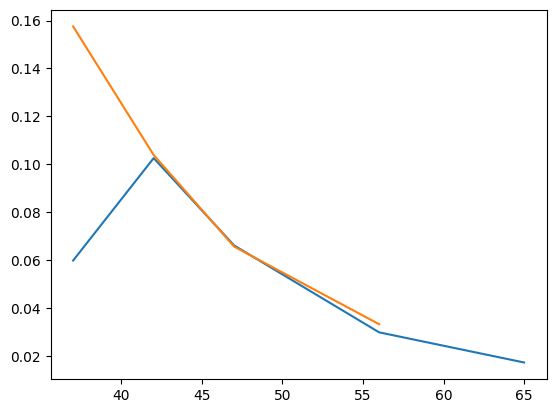

In [13]:
plt.plot(Z[1:], ratio_alpha)
plt.plot(Z[1:-1], ratio_beta)
plt.show()
# NOTE: Probably actually want to plot this against the energy of the photon, although
# that's just linear in Z, so doesn't matter much

In [14]:
# By how much does the escape:normal ratio change with Z?
# Larger Z giving fewer escape counts
rough_slope = (ratio_alpha[2] - ratio_alpha[1])/(Z[3] - Z[2])
print(f"Seeing roughly a slope of {rough_slope} per proton")

Seeing roughly a slope of -0.007298077503891759 per proton


## Monte Carlo Simulation

In [15]:
# Fit a 1/E^3 to the data for attenuation coefficients
E = np.array([1.0, 1.1, 1.22, 1.23, 1.25, 1.2])
mu_over_rho = np.array([])

def curve(E, a, b):
    return a / (E - b)**3.0

popt, pcov = curve_fit(f=curve, xdata=E, ydata=mu_over_rho, sigma=np.ones(E.size) / 100.0, p0=[-0.05, 1], absolute_sigma=True)
print(popt, np.sqrt(pcov[0]))

x = np.linspace(0, 1, 10000)
plt.plot(x, curve(x, *popt))
plt.scatter(E, mu_over_rho)

ValueError: `ydata` must not be empty!

In [ ]:
D = 2.18 # cm
r = 5.11 / 2.0 # cm
rho = 5.323 # g/cm^3

def rand_solid_angle(samples):
    u = np.random.uniform(size=samples)
    v = np.random.uniform(size=samples)
    theta = 2 * np.pi * u
    phi = np.arccos(2*v - 1)
    return theta, phi


print(xraydb.xray_edges("Ge"))

{'K': XrayEdge(energy=11103.0, fyield=0.523313, jump_ratio=7.392), 'L1': XrayEdge(energy=1414.6, fyield=0.0024, jump_ratio=1.13638), 'L2': XrayEdge(energy=1248.1, fyield=0.013, jump_ratio=1.4), 'L3': XrayEdge(energy=1217.0, fyield=0.015, jump_ratio=3.684), 'M1': XrayEdge(energy=180.1, fyield=9.1e-06, jump_ratio=1.04), 'M2': XrayEdge(energy=124.9, fyield=2.6e-05, jump_ratio=1.058), 'M3': XrayEdge(energy=120.8, fyield=0.0, jump_ratio=1.11304), 'M4': XrayEdge(energy=29.8, fyield=0.0027, jump_ratio=1.0), 'M5': XrayEdge(energy=29.2, fyield=0.0, jump_ratio=1.0), 'N1': XrayEdge(energy=5.0, fyield=1.01053e-05, jump_ratio=1.0), 'N2': XrayEdge(energy=3.0, fyield=0.0109474, jump_ratio=1.0), 'N3': XrayEdge(energy=3.0, fyield=0.0109474, jump_ratio=1.0)}


Yield:  0
Yield:  0.523313
Yield:  0.523313
Yield:  0.523313
Yield:  0.523313
Yield:  0.523313


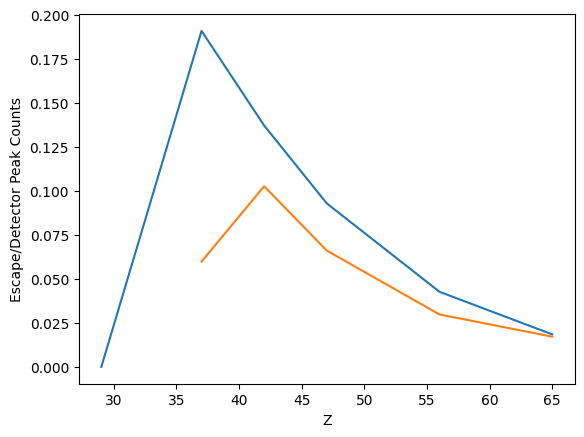

In [ ]:
# Interpolation...
E_Ge_ka = 9886.42 # eV
E_Ge_kb = 10982.1 # eV

mu_E1 = 14.0 * rho  # meters # MAKE SURE TO INTERPOLATE: goes as 1/E^3
mu_E2 = 37.0 * rho # meters
# prob_auger = 0.465 # 1.0 - 0.583 # https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/epdf/10.1002/xrs.1300040211

def simulate_ba(E, samples=1000000):
    """Returns escape peak ratio"""
    
    d_1 = np.random.exponential(scale=1.0/xraydb.mu_elam("Ge", E), size=samples)
    
    d_1 = d_1[np.where(d_1 < D)]
    passed_through = samples - d_1.size
    
    # Auger Effect
    fluor_yield = xraydb.fluor_yield("Ge", "K", "Ka", E)[0]
    print("Yield: ", fluor_yield)
    d_1 = np.random.choice(d_1, size=int(fluor_yield * d_1.size), replace=False)
    
    theta = 2 * np.pi * np.random.uniform(size=d_1.size)
    d_2 = np.random.exponential(scale=1.0/xraydb.mu_elam("Ge", E_Ge_ka), size=d_1.size)
        
        
    # Do I need to multiply by the sine theta for solid angle? I feel like not
    
    num_escaped = np.where((d_1 + d_2*np.cos(theta) > D) | (d_1 + d_2*np.cos(theta) < 0.0) | (d_2*np.sin(theta) > r))[0].size
    
#     print(f"Passed through: {100.0 * passed_through / samples}%")
#     print(f"Escaped given no pass through: {100 * num_escaped / (samples - passed_through)}%")
    
    return num_escaped / (samples - passed_through - num_escaped)

ratios = np.array([simulate_ba(E * 1000.0) for E in E_ka])

# alpha_beta_combined = [-1, ratio_alpha[1], ratio_alpha[2], ratio_beta[3], ratio_alpha[4]]

plt.plot(Z, ratios)
plt.plot(Z[1:], ratio_alpha)
# plt.plot(Z[1:-1], ratio_beta)
# plt.plot(Z[1:], alpha_beta_combined[1:])
# plt.plot(Z[1:-1], np.abs(ratio_beta - ratios[1:-1]))
plt.xlabel("Z")
plt.ylabel("Escape/Detector Peak Counts")
plt.show()

In [ ]:
def mass_att_coef(E):
    # Get Ge mass attenuation coefficients here: https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z32.html
    # Also an option: https://xraypy.github.io/XrayDB/python.html#absorption-and-scattering-cross-sections
    # return xraydb.mu_elam("Ge", E)
    return 13.85 / rho / 100.0 # meters


# def mc_prob_escape(E_0, size):
#     original_size = size
#     mu_0 = mass_att_coef(E_0)
#     # I think the coefficients you are finding take rho into account already
#     first_x_ray_stop = np.random.exponential(scale=1.0/mu_0, size=size)
#     unescaped = first_x_ray_stop[np.where(first_x_ray_stop < Ge_depth)]
#     size = unescaped.size
#     first_escaped = original_size - size
    
#     # Auger Effect
#     prob_auger = 0.02
#     unescaped = np.random.choice(unescaped, size=int((1 - prob_auger) * unescaped.size), replace=False)
#     size = unescaped.size
    
#     angles = 2 * np.pi * np.random.uniform(size=size)
#     mu_1 = Ge_Ge_mu# mass_att_coef(E_Ge)
#     second_x_ray_dist = np.random.exponential(scale=1.0/mu_1, size=size)
#     second_x_ray_stop = unescaped + second_x_ray_dist * np.cos(angles)
#     second_x_ray_stop_radius = second_x_ray_dist * np.sin(angles)
#     unescaped = second_x_ray_stop[np.where((second_x_ray_stop < Ge_depth) & (second_x_ray_stop > 0) & (second_x_ray_stop_radius < r))]
#     escaped = size - unescaped.size
# #     print(original_size, size, escaped)
#     return escaped / original_size, first_escaped / original_size

print(mc_prob_escape(0.2, 1000000))
# This gives you the probability of escape from one incoming x-ray photon
# But there is much more to take into account
# Chance of the original x-ray passing completely through (done)
# Does every x-ray that goes in contribute either to voltage or to an escape?
# I think there are other options...pair creation not relevant
# What if a lower energy than even 10keV escapes from second order effects? Neglectable prob
# If the simple assumption is true, then
def esc_norm_ratio(prob_escape, prob_orig_escape):
    return prob_escape / (1 - prob_escape - prob_orig_escape)

NameError: name 'mc_prob_escape' is not defined

In [ ]:
# Information I need:
# Dimensions of the Germanium detector, and general specs


In [ ]:
# Testing first with Barium, 31.86 keV k_alpha peak
# This is actually super good if your Ge_depth is right, but no idea
prob_escape, prob_first_escape = mc_prob_escape(1.0, 10000000)
print(prob_escape)
esc_norm_ratio(prob_escape, prob_first_escape)

NameError: name 'mc_prob_escape' is not defined

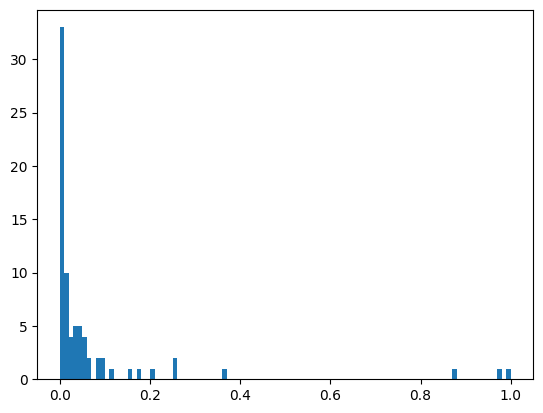

In [ ]:
exits = np.array([1000.0, 970.0, 875.0, 365.0, 250.0, 250.0, 200.0, 170.0, 150.0, 115.0, 90.0, 90.0, 85.0, 85.0, 65.0, 60.0, 58.0, 50.8, 50.0, 50.0, 48.0, 45.0, 43.4, 40.0, 40.0, 39.0, 35.0, 30.0, 30.0, 30.0, 22.8, 20.0, 20.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 12.5, 10.0, 10.0, 10.0, 9.0, 8.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.6, 0.5, 0.4, 0.3, 0.1, 0.1, 0.1, 0.0])
x_bnb = np.max(exits)
exits /= x_bnb
counts, x, _ = plt.hist(exits, bins=100)
x = x[:-1]
indices = np.where(counts != 0)
counts = counts[indices]
x = x[indices]

[-0.41258816  0.76655044] [[0.00121591 0.00551894]
 [0.00551894 0.03341713]]


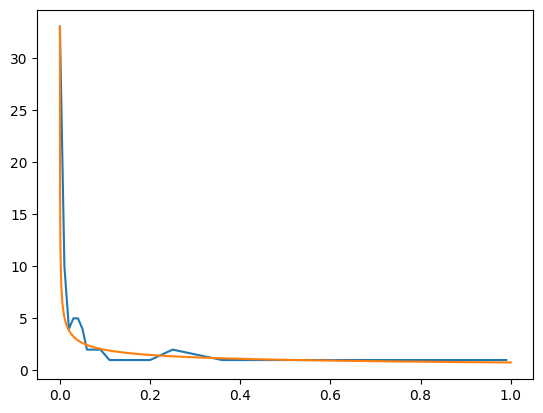

In [ ]:
def power_law(x, n, a):
    return a * np.power((x + 0.0001), n)
def line(x, m, b):
    return m * x + b
popt, pcov = curve_fit(f=power_law, xdata=x, ydata=counts, sigma=np.sqrt(counts), p0=[-0.05, 1], absolute_sigma=True)
print(popt, pcov)
plt.plot(x, counts)
x_lin = np.linspace(0.00001, 1, 10000)
plt.plot(x_lin, power_law(x_lin, *popt))

In [ ]:
p_admission = 0.5
p_depression = 0.1 # https://scholar.harvard.edu/files/bolotnyy/files/bbb_mentalhealth_paper.pdf

def simulate_continue(n_samples=10e3):
    exit_dist = x_bnb * np.random.power(popt[0] + 1, size=n_samples)

def simulate_grad(n_samples=10e3):
    p_admission = 0.5
    admitted = np.random.binomial(1, p_admission, size=n_samples).
    
    

SyntaxError: invalid syntax (1394704771.py, line 9)

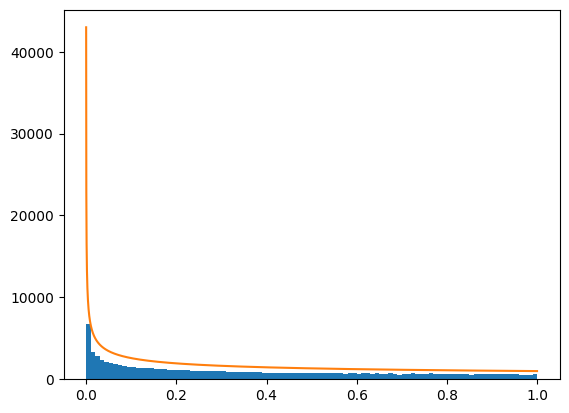

In [ ]:
n = 100000
bins = 100
plt.hist(np.random.power(popt[0] + 1, size=n), bins=bins)
plt.plot(x_lin, n / bins / popt[1] * power_law(x_lin, *popt))
plt.show()

In [ ]:
np.trim_zeros(np.random.binomial(1, 0.5, size=10))

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

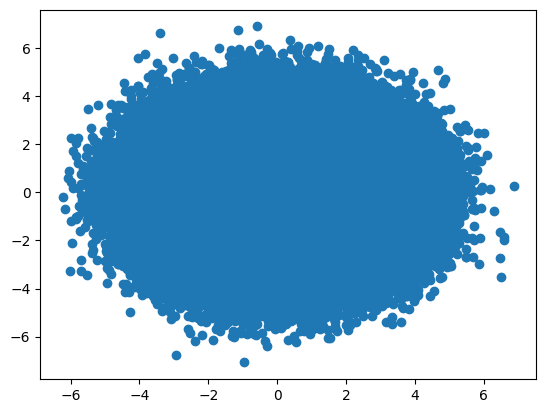

In [ ]:
n = 1000000
a = np.random.normal(0, 1, size=n)
b = np.random.normal(0, 1, size=n)
x = a + b
y = a - b
plt.scatter(x, y)

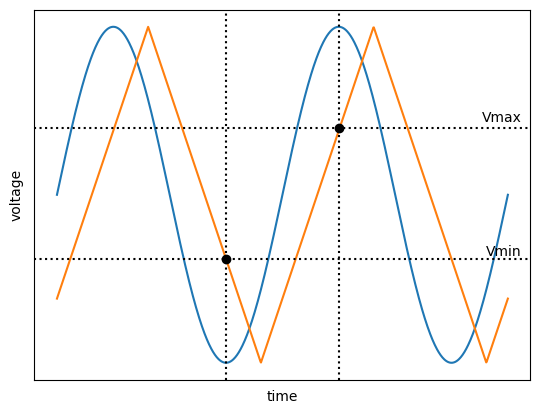

In [ ]:
x = np.linspace(0, 4 * np.pi, 1000)
plt.plot(np.sin(x))
plt.plot(np.abs(np.mod((x + 0.6)/(2*np.pi) - 0.5, 1) - 0.5) * 4 - 1)

# Label the axes
plt.xlabel('time')
plt.ylabel('voltage')

# Remove axis labels
plt.xticks([])
plt.yticks([])

# Draw a vertical dotted line at x=np.pi
plt.axvline(x=625, linestyle='dotted', color="black")
plt.axvline(x=375, linestyle='dotted', color="black")

#Draw a horizontal dotted line at y=0
plt.axhline(y=0.4, linestyle='dotted', color="black")
plt.axhline(y=-0.38, linestyle='dotted', color="black")

plt.plot(625, 0.4, 'o', color="black")
plt.plot(375, -0.38, 'o', color="black")

#Label the horizontal line at y=0
plt.text(1030, 0.5, 'Vmax', horizontalalignment='right', verticalalignment='top')
plt.text(1030, -0.3, 'Vmin', horizontalalignment='right', verticalalignment='top')

plt.savefig("fig.pdf")

In [16]:
a = np.arange(5)
np.where(a < 3)[0].size

3